In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [172]:
data = pd.read_csv('clustering_data.csv', low_memory=False)

data.head()

,CircleName,RegionName,DivisionName,OfficeName,Pincode,OfficeType,Delivery,District,StateName,Latitude,Longitude
0,Andhra Pradesh Circle,Kurnool Region,Hindupur Division,Peddakotla B.O,515631,BO,Delivery,ANANTAPUR,ANDHRA PRADESH,14.5689,77.85624
1,Andhra Pradesh Circle,Kurnool Region,Hindupur Division,Pinnadhari B.O,515631,BO,Delivery,ANANTAPUR,ANDHRA PRADESH,14.5281,77.857014
2,Andhra Pradesh Circle,Kurnool Region,Hindupur Division,Yerraguntapalle B.O,515631,BO,Delivery,ANANTAPUR,ANDHRA PRADESH,14.561111,77.85715
3,Andhra Pradesh Circle,Kurnool Region,Hindupur Division,Obulareddipalli B.O,515581,BO,Delivery,ANANTAPUR,ANDHRA PRADESH,14.2488,78.2588
4,Andhra Pradesh Circle,Kurnool Region,Hindupur Division,Odulapalli B.O,515581,BO,Delivery,ANANTAPUR,ANDHRA PRADESH,14.24555,78.2477


In [173]:
filtered_data = data[data['CircleName'] == 'Telangana Circle'].copy()

filtered_data.head()

,CircleName,RegionName,DivisionName,OfficeName,Pincode,OfficeType,Delivery,District,StateName,Latitude,Longitude
138,Telangana Circle,Hyderabad Region,Nizamabad Division,Arsapalli B.O,503186,BO,Delivery,NIZAMABAD,TELANGANA,18.6845544,78.0773742
139,Telangana Circle,Hyderabad Region,Nizamabad Division,Camp Ootpalli B.O,503180,BO,Delivery,NIZAMABAD,TELANGANA,18.5329923,77.618717
140,Telangana Circle,Hyderabad Region,Nizamabad Division,Eraspalli B.O,503180,BO,Delivery,NIZAMABAD,TELANGANA,18.5329923,77.618717
141,Telangana Circle,Hyderabad Region,Nizamabad Division,Singitham B.O,503187,BO,Delivery,KAMAREDDY,TELANGANA,18.3096558,77.9466324
142,Telangana Circle,Hyderabad Region,Nizamabad Division,Mahmadpur B.O,503101,BO,Delivery,KAMAREDDY,TELANGANA,18.2108201,78.4853495


In [174]:
filtered_data['Latitude'] = pd.to_numeric(filtered_data['Latitude'], errors='coerce')
filtered_data['Longitude'] = pd.to_numeric(filtered_data['Longitude'], errors='coerce')

# Drop rows where either lat or lon is missing or non-numeric
filtered_data = filtered_data.dropna(subset=['Latitude', 'Longitude'])

# Ensure the columns are explicitly typed as float
filtered_data['Latitude'] = filtered_data['Latitude'].astype(float)
filtered_data['Longitude'] = filtered_data['Longitude'].astype(float)

### Outlier Removal Based on Geographical Boundaries

To clean our dataset and improve clustering performance, we apply boundary-based filtering to remove geographical outliers. Specifically, we retain only those data points whose latitude and longitude fall within a defined bounding box:
- Latitude: 15° to 23°
- Longitude: 75° to 82°

Any points outside this range are considered outliers and are excluded from further analysis. This helps focus the clustering on the region of interest and reduces noise in the results.

In [175]:
min_lat = 15
max_lat = 23
min_lon = 75
max_lon = 82

# Filter data to keep only points within these boundaries so as to remove outliers
more_filtered_data = filtered_data[
    (filtered_data['Latitude'] >= min_lat) & 
    (filtered_data['Latitude'] <= max_lat) & 
    (filtered_data['Longitude'] >= min_lon) & 
    (filtered_data['Longitude'] <= max_lon)
]

In [176]:
# Plot the filtered data
fig = px.scatter_map(
    more_filtered_data,
    lat="Latitude",
    lon="Longitude",
    hover_name="Pincode",
    height=600,
    zoom=5
)

fig.update_layout(
    mapbox_style="open-street-map",
    margin={"r":0,"t":0,"l":0,"b":0}
)

fig.show()

### Converting Between Latitude/Longitude and Cartesian Coordinates

This code snippet performs conversions between geographic coordinates (latitude and longitude) and 3D Cartesian coordinates on a unit sphere.

#### Why This Conversion?
Latitude and longitude are angular measurements on a spherical surface, which are not ideal for operations like clustering that rely on Euclidean distance. Converting to 3D Cartesian coordinates on a unit sphere allows more accurate geometric computations, especially for distance-based clustering.

#### Conversion: Lat/Lon → Cartesian
Given:
- Latitude (φ) and Longitude (λ) in degrees

Convert to radians:
- φ_rad = radians(φ)
- λ_rad = radians(λ)

Then compute:
- **x = cos(φ_rad) × cos(λ_rad)**
- **y = cos(φ_rad) × sin(λ_rad)**
- **z = sin(φ_rad)**

This maps the point onto a unit sphere centered at the origin.

#### Conversion: Cartesian → Lat/Lon
Normalize the 3D vector to ensure it's on the unit sphere, then:
- **Latitude = arcsin(z)** (inverse of sin(φ))
- **Longitude = arctan2(y, x)** (gives angle in correct quadrant)

These are then converted back to degrees. This enables accurate round-trip conversion between the two coordinate systems.

In [177]:
def lat_lon_to_cartesian(lat, lon):
    # Convert latitude and longitude from degrees to radians
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    
    # Calculate Cartesian coordinates on a unit sphere
    x = np.cos(lat_rad) * np.cos(lon_rad)
    y = np.cos(lat_rad) * np.sin(lon_rad)
    z = np.sin(lat_rad)
    
    # Stack x, y, z into a single (N, 3) array
    return np.column_stack((x, y, z))


def cartesian_to_lat_lon(cartesian):
    # Compute the magnitude of each vector
    norm = np.linalg.norm(cartesian, axis=1, keepdims=True)
    
    # Normalize vectors to ensure they lie on the unit sphere
    normalized = cartesian / norm
    
    # Extract x, y, z components
    x, y, z = normalized[:, 0], normalized[:, 1], normalized[:, 2]
    
    # Convert Cartesian coordinates to latitude and longitude in degrees
    lat = np.degrees(np.arcsin(z))
    lon = np.degrees(np.arctan2(y, x))
    
    # Stack lat, lon into a single (N, 2) array
    return np.column_stack((lat, lon))

### Spherical K-Means Clustering on Geographic Coordinates

This function implements the **K-Means clustering algorithm** tailored for geographic coordinates (latitude and longitude). Since K-Means relies on Euclidean distances and direct lat/lon distances are not Euclidean, we first **convert lat/lon to 3D Cartesian coordinates on a unit sphere**.

#### Key Concepts and Steps:

1. **Conversion to Cartesian Coordinates**:
   - Latitude and longitude are converted to 3D coordinates on a unit sphere using the `lat_lon_to_cartesian()` function. This allows us to use standard Euclidean distance for clustering.

2. **Initialization**:
   - `k` points are randomly selected as initial centroids from the dataset in Cartesian space.

3. **Iterative Refinement**:
   For each iteration:
   - **Assignment Step**: Each point is assigned to the nearest centroid using Euclidean distance.
   - **Update Step**: New centroids are computed as the mean of the points assigned to each cluster.
   - **Normalization**: Since averaging might move centroids off the unit sphere, we normalize them to project them back onto the sphere.
   - **Convergence Check**: If the change in centroid positions is below a tolerance threshold (`tol`), the algorithm stops.

4. **Final Output**:
   - The final centroids are converted back to latitude and longitude using `cartesian_to_lat_lon()`.
   - Cluster labels and centroid coordinates are returned.

#### Why Use This Approach?
Standard K-Means does not account for the curvature of the Earth. This method ensures accurate clustering over the globe by treating locations as vectors on the surface of a sphere and maintaining that geometry throughout the process.

In [178]:
def kmeans(X_latlon, k, max_iters=100, tol=1e-4):
    np.random.seed(42)  # Set random seed for reproducibility
    
    # Convert latitude/longitude data to Cartesian coordinates
    X_cart = lat_lon_to_cartesian(X_latlon[:, 0], X_latlon[:, 1])
    
    # Randomly select initial centroids from the data
    initial_indices = np.random.choice(len(X_cart), k, replace=False)
    centroids_cart = X_cart[initial_indices].copy()
    
    for _ in range(max_iters):
        # Compute distances from each point to all centroids
        distances = np.linalg.norm(X_cart[:, np.newaxis] - centroids_cart, axis=2)
        
        # Assign each point to the nearest centroid
        labels = np.argmin(distances, axis=1)
        
        # Save current centroids for convergence check
        old_centroids_cart = centroids_cart.copy()
        
        # Recompute centroids as mean of assigned points
        for j in range(k):
            if np.sum(labels == j) > 0:
                # Take mean of points in cluster j
                centroids_cart[j] = X_cart[labels == j].mean(axis=0)
                # Normalize to lie on unit sphere
                centroids_cart[j] = centroids_cart[j] / np.linalg.norm(centroids_cart[j])
        
        # Stop if centroids have moved less than the tolerance
        if np.linalg.norm(centroids_cart - old_centroids_cart) < tol:
            break
    
    # Convert final centroids back to latitude/longitude
    centroids_latlon = cartesian_to_lat_lon(centroids_cart)
    
    return centroids_latlon, labels  # Return centroids and cluster labels

### Calculating WCSS (Within-Cluster Sum of Squares) on a Sphere

This function computes the **Within-Cluster Sum of Squares (WCSS)** for different values of **k** (number of clusters) using the output of the spherical K-Means algorithm. WCSS is a key metric used in the **Elbow Method** to help determine the optimal number of clusters.

#### Key Concepts:

- **WCSS** measures the total squared distance between each point and its cluster's centroid.
- Lower WCSS indicates more compact clusters. However, WCSS naturally decreases as `k` increases, which is why we use the **Elbow Method** to find the optimal trade-off.

#### Steps Explained:

1. **Convert Coordinates**:
   - Input latitude/longitude points are first converted to 3D Cartesian coordinates to work with Euclidean distance in 3D space.

2. **Iterate Over k Values**:
   - For each value of `k` in the specified range, the function:
     - Runs the spherical K-Means algorithm to get cluster centroids and labels.
     - Converts centroids to Cartesian space.
     - Computes the sum of squared Euclidean distances from each point to its corresponding cluster centroid.

3. **Sum of Squared Distances**:
   - For each cluster:
     - Calculate the squared norm (distance) between each point and its centroid.
     - Sum these distances to get WCSS for the cluster, and accumulate over all clusters.

In [179]:
def calculate_wcss_cartesian(X_latlon, k_range):
    wcss = []
    
    # Convert to Cartesian coordinates once
    X_cart = lat_lon_to_cartesian(X_latlon[:, 0], X_latlon[:, 1])
    
    for k in k_range:
        # Run k-means
        centroids_latlon, labels = kmeans(X_latlon, k)
        
        # Convert centroids to Cartesian
        centroids_cart = lat_lon_to_cartesian(centroids_latlon[:, 0], centroids_latlon[:, 1])
        
        # Calculate WCSS
        ss = 0
        for i in range(k):
            cluster_points = X_cart[labels == i]
            if len(cluster_points) > 0:
                # Calculate squared distances to centroid
                # We're using Euclidean distance in 3D space as an approximation
                centroid = centroids_cart[i]
                ss += np.sum(np.linalg.norm(cluster_points - centroid, axis=1) ** 2)
        
        wcss.append(ss)
    
    return wcss

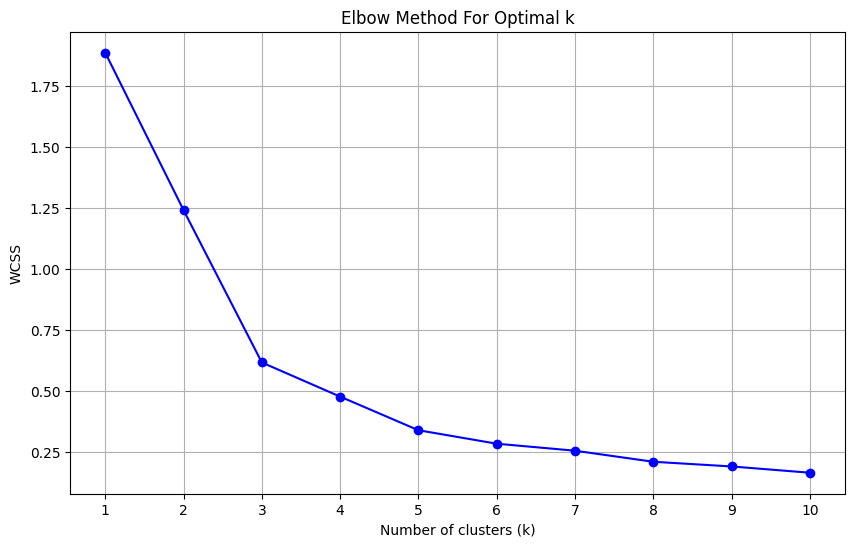

In [180]:
# Define range of k values to evaluate
k_range = range(1, 11)

# Compute Within-Cluster Sum of Squares (WCSS) for each k
wcss = calculate_wcss_cartesian(X, k_range)

# Plot the Elbow Curve to help choose optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, 'bo-')
plt.title('Elbow Method For Optimal k')  
plt.xlabel('Number of clusters (k)')     
plt.ylabel('WCSS')                      
plt.grid(True)                           
plt.xticks(k_range)                      
plt.show()                            

In [181]:
# Run the clustering
k = 3
X = more_filtered_data[['Latitude', 'Longitude']].values
centroids, labels = kmeans(X, k)

# Create a copy of the filtered data before modifying it
more_filtered_data = more_filtered_data.copy()

# Add cluster labels to DataFrame
more_filtered_data['Cluster'] = labels

# Create centroids DataFrame
centroid_df = pd.DataFrame(centroids, columns=['Latitude', 'Longitude'])
centroid_df['Cluster'] = range(1, k+1)  # Add cluster numbers

In [183]:
# Convert cluster numbers to strings to ensure discrete color mapping
more_filtered_data['Cluster'] = more_filtered_data['Cluster'].astype(str)
centroid_df['Cluster'] = centroid_df['Cluster'].astype(str)

# Use a distinct color sequence
color_sequence = px.colors.qualitative.Set1

# Create the scatter map plot for the clusters
fig = px.scatter_map(
    more_filtered_data,
    lat='Latitude',
    lon='Longitude',
    color='Cluster',
    color_discrete_sequence=color_sequence,
    hover_name='Pincode',
    zoom=5,
    height=600
)

# Create the centroid trace
centroid_trace = px.scatter_map(
    centroid_df,
    lat='Latitude',
    lon='Longitude',
    text='Cluster',
    hover_name='Cluster',
    zoom=5,
).data[0]

# Customize centroid markers
centroid_trace.marker.size = 20
centroid_trace.marker.color = 'black'
centroid_trace.textfont = dict(size=14, color='white')
centroid_trace.textposition = 'middle center'

# Add centroid trace
fig.add_trace(centroid_trace)
fig.update_layout(showlegend=False)
fig.show()